In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
# drscarlat_melanoma_path = kagglehub.dataset_download('drscarlat/melanoma')
andrewmvd_isic_2019_path = kagglehub.dataset_download('andrewmvd/isic-2019')

#andrewmvd_isic_2019_path = '/content/drive/MyDrive/isic-2019'
# surajghuwalewala_ham1000_segmentation_and_classification_path = kagglehub.dataset_download('surajghuwalewala/ham1000-segmentation-and-classification')

print('Data source import complete.')


Data source import complete.


In [ ]:
# print(drscarlat_melanoma_path)
print(andrewmvd_isic_2019_path)
# print(surajghuwalewala_ham1000_segmentation_and_classification_path)

/root/.cache/kagglehub/datasets/andrewmvd/isic-2019/versions/1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# os.listdir(drscarlat_melanoma_path)
os.listdir(andrewmvd_isic_2019_path)
# os.listdir(surajghuwalewala_ham1000_segmentation_and_classification_path)


['ISIC_2019_Training_Metadata.csv',
 'ISIC_2019_Training_GroundTruth.csv',
 'ISIC_2019_Training_Input']

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.onnx
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from tqdm import tqdm

In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda"
                      if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation
columns_rearranged = ['image', 'NV', 'MEL', 'BCC', 'AKIEC', 'DF', 'VASC', 'BKL', 'SCC']

# skin_cancer_df = pd.read_csv('/root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2/GroundTruth.csv')
# skin_cancer_df.drop(columns=['BKL'], inplace=True)
# skin_cancer_df = skin_cancer_df[columns_rearranged]

# skin_cancer_2019_df = pd.read_csv('/root/.cache/kagglehub/datasets/andrewmvd/isic-2019/versions/1/ISIC_2019_Training_GroundTruth.csv')
skin_cancer_2019_df = pd.read_csv(os.path.join(andrewmvd_isic_2019_path, 'ISIC_2019_Training_GroundTruth.csv'))
#skin_cancer_2019_df.drop(columns=['BKL', 'SCC', 'UNK'], inplace=True)
skin_cancer_2019_df.rename(columns={'AK': 'AKIEC'}, inplace=True)
skin_cancer_2019_df = skin_cancer_2019_df[columns_rearranged]



Using device: cuda


In [ ]:
# NV - Melanocytic Nevus: Benign mole from melanocytes.
# MEL - Melanoma: Malignant, high-risk skin cancer from melanocytes.
# BCC - Basal Cell Carcinoma: Common, low-risk skin cancer.
# AKIEC - Actinic Keratosis: Precancerous lesion from sun exposure.
# DF - Dermatofibroma: Benign, fibrous skin growth.
# VASC - Vascular Lesion: Benign growth involving blood vessels.

# BKL - Benign Keratosis
# SCC - Squamous Cell Carcinoma
# UNK

In [ ]:
multiclass_categories = {
    0: 'NV',
    1: 'MEL',
    2: 'BCC',
    3: 'AKIEC',
    4: 'DF',
    5: 'VASC',
    6: 'BKL',
    7: 'SCC'
}

filenames_list, multiclass_categories_list = [], []

base_paths = [
#     ("/root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2/images", skin_cancer_df),
#     ("/root/.cache/kagglehub/datasets/drscarlat/melanoma/versions/1/DermMel/", [['test', 'valid'], ['NotMelanoma', 'Melanoma']]),
     ("/root/.cache/kagglehub/datasets/andrewmvd/isic-2019/versions/1/ISIC_2019_Training_Input/ISIC_2019_Training_Input", skin_cancer_2019_df)
]


#base_paths = [("/content/drive/MyDrive/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input", skin_cancer_2019_df)]


In [ ]:
for base_path, database in base_paths:
    if isinstance(database, pd.DataFrame):
        for row in database.itertuples(index=False):
            filename = os.path.join(base_path, row[0]) + '.jpg'
            filenames_list.append(filename)
            multiclass_index = np.argmax(row[1:])
            multiclass_categories_list.append(multiclass_index)
    else:
        for sub_directory in database[0]:
            for sub_sub_directory in database[1]:
                final_path = os.path.join(base_path, sub_directory, sub_sub_directory)
                for filename in os.listdir(final_path):
                    filenames_list.append(os.path.join(final_path, filename))
                    if sub_sub_directory in ['nevus', 'NotMelanoma']:
                        multiclass_categories_list.append(0)
                    else:
                        multiclass_categories_list.append(database[1].index(sub_sub_directory))

multiclass_df = pd.DataFrame({"filename": filenames_list, "category": multiclass_categories_list})
multiclass_df = multiclass_df.sample(frac=1).reset_index(drop=True)

multiclass_class_counts = np.bincount(multiclass_categories_list)
# multiclass_class_weights = {i: len(multiclass_categories_list) / (2.0 * count) for i, count in enumerate(multiclass_class_counts)}
multiclass_class_weights = {i: 1 for i, count in enumerate(multiclass_class_counts)}

print(f"Multi-class weights: {multiclass_class_weights}")

print(len(multiclass_categories_list))
print(multiclass_df['category'].value_counts(normalize=False))  # Check proportions


Multi-class weights: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
25331
category
0    12875
1     4522
2     3323
6     2624
3      867
7      628
5      253
4      239
Name: count, dtype: int64


In [ ]:
multiclass10percent_df = multiclass_df.groupby('category', group_keys=False).apply(
    lambda x: x.sample(frac=0.1, random_state=42)
)

print(multiclass10percent_df['category'].value_counts(normalize=False))  # Check proportions


category
0    1288
1     452
2     332
6     262
3      87
7      63
5      25
4      24
Name: count, dtype: int64


<ipython-input-10-19e682c11ae9>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  multiclass10percent_df = multiclass_df.groupby('category', group_keys=False).apply(


In [ ]:
# Use drop to remove the 10% of the rows in the stratified DF from the full multiclass_df
multiclass90percent = multiclass_df.drop(multiclass10percent_df.index)
print("\nRemaining Dataset Category Counts:")
print(multiclass90percent['category'].value_counts(normalize=False))


Remaining Dataset Category Counts:
category
0    11587
1     4070
2     2991
6     2362
3      780
7      565
5      228
4      215
Name: count, dtype: int64


<ipython-input-12-be8381d454a9>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni, x=uni.index, y='Count', palette='icefire', width=0.4).set_title('Class distribution in Dataset', fontsize=15)


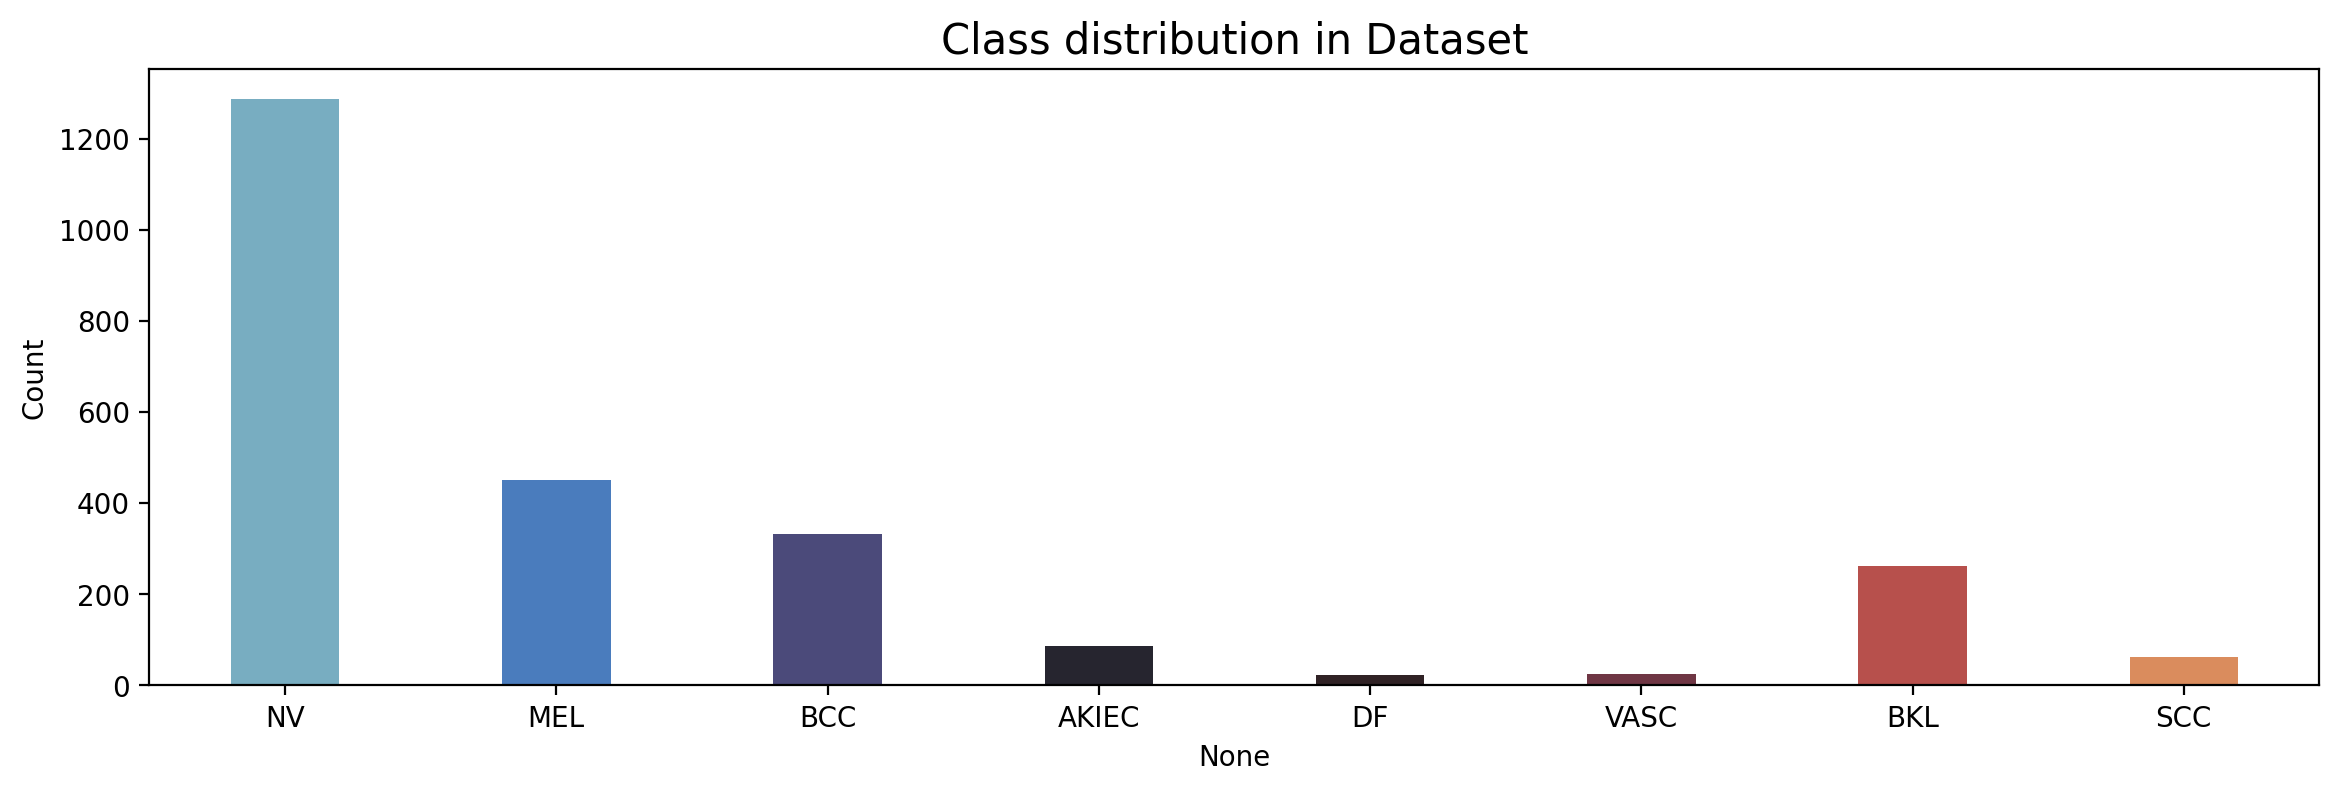

In [ ]:
# Visualization
label, count = np.unique(multiclass10percent_df.category, return_counts=True)
uni = pd.DataFrame(data=count, index=multiclass_categories.values(), columns=['Count'])

plt.figure(figsize=(14, 4), dpi=200)
sns.barplot(data=uni, x=uni.index, y='Count', palette='icefire', width=0.4).set_title('Class distribution in Dataset', fontsize=15)
plt.show()

In [ ]:
# Train-validation-test split
multiclass_train_df, multiclass_temp_df = train_test_split(multiclass10percent_df, test_size=0.2, stratify=multiclass10percent_df['category'], random_state=42)
multiclass_cv_df, multiclass_test_df = train_test_split(multiclass_temp_df, test_size=0.5, stratify=multiclass_temp_df['category'], random_state=42)


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/GT_OMSA/CS7643_DL/project')
from utils import blurring, remove_hair
# from cv2 import GaussianBlur, medianBlur
import cv2

In [ ]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, blackhat_threshold, kernel_size_hair, kernel_size_blur, blur_func, doBlur, transform=None,):
        self.dataframe = dataframe
        self.transform = transform
        self.blackhat_threshold = blackhat_threshold
        self.kernel_size_tuple = (kernel_size_hair, kernel_size_hair)
        self.kernel_size_blur = kernel_size_blur
        self.blur_func = blur_func
        self.doBlur = doBlur

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        # image = Image.open(img_path).convert('RGB')
        image = cv2.imread(img_path)
        label = int(self.dataframe.iloc[idx, 1])
        cleaned_image = remove_hair(image, kernel_size_tuple=self.kernel_size_tuple, blackhat_threshold=self.blackhat_threshold)
        if(self.doBlur):
          cleaned_image = blurring(cleaned_image, kernel_size=self.kernel_size_blur,blur_func=self.blur_func)

        cleaned_image = Image.fromarray(cleaned_image)

        if self.transform:
            cleaned_image = self.transform(cleaned_image)

        return cleaned_image, label

image_size = (224, 224)
batch_size = 32

In [ ]:
# SELF-SUPERVISED LEARNING
#####################################
# Transforms and Pre-Processing
#####################################
transform_SelfSL = transforms.Compose([
    # TODO: can consider larger resize
    transforms.Resize(image_size),
    transforms.RandomCrop(image_size, padding=10),  # Random cropping with padding
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
        transforms.ColorJitter(
        brightness=0.1,  # Adjust brightness by ±10%
        contrast=0.1,    # Adjust contrast by ±10%
        saturation=0.1,  # Adjust saturation by ±10%
        hue=0.02         # Adjust hue by ±2%
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # add color jitter
])

In [ ]:
# SUPERVISED LEARNING
#####################################
# Transforms and Pre-Processing
#####################################
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Pre-processing
blackhat_threshold = 9
kernel_size_hair = 15
kernel_size_blur = 5
blur_func = cv2.GaussianBlur
doBlur = True

# Prepare dataset
train_dataset = SkinCancerDataset(multiclass_train_df, blackhat_threshold, kernel_size_hair, kernel_size_blur, blur_func, doBlur, transform=transform)
val_dataset = SkinCancerDataset(multiclass_cv_df, blackhat_threshold, kernel_size_hair, kernel_size_blur, blur_func, doBlur, transform=transform)
test_dataset = SkinCancerDataset(multiclass_test_df, blackhat_threshold, kernel_size_hair, kernel_size_blur, blur_func, doBlur, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=14)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=14)

In [ ]:
# EFFICIENT NET FOR SUPERVISED
class EfficientNetB3(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB3, self).__init__()
        # Load pretrained EfficientNet B3
        self.model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        # Get the number of input features for the classifier layer
        in_features = self.model.classifier[1].in_features
        # Replace the final classification layer
        self.model.classifier[1] = nn.Linear(in_features, num_classes)
        # Softmax for output probabilities
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        return x

# Define the number of classes
num_classes = len(multiclass_categories)  # Use your class count
# Initialize the model
model = EfficientNetB3(num_classes=num_classes)
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Check available GPUs
print([torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

['NVIDIA A100-SXM4-40GB']


In [ ]:
#FULLY SUPERVISED TRG
def train_one_epoch(epoch, model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    correct_train = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", ncols=100):
        images, labels = images.to(device, dtype=torch.float32), labels.cuda().long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / len(train_loader.dataset)

    return train_loss, train_accuracy

def validate_one_epoch(epoch, model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", ncols=100):
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / len(val_loader.dataset)

    return val_loss, val_accuracy

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device, criterion):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(epoch, model, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy = validate_one_epoch(epoch, model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies, best_val_loss

# train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device)
#train_losses, train_accuracies, val_losses, val_accuracies, best_val_loss = train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device, criterion)

In [ ]:
#PLOTTING
def plot_curves(train_losses, val_losses, filename):
    '''
    '''
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='valid')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve - '+filename)
    plt.savefig(filename+'.png')
    plt.show()


In [ ]:
#HYPERPARAM TUNING
def get_best_val_loss(
    train_loader,
    val_loader,
    lr,
    weight_decay,
    model=None
):
    """
    Initializes and trains the EfficientNetB3 model with the given configuration.
    Returns the best validation loss.
    """
    # Configuration
    num_classes = len(multiclass_categories)  # Replace with your global variable
    class_weights = torch.tensor(list(multiclass_class_weights.values()), dtype=torch.float32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    early_stopping_patience = 4

    # Initialize the EfficientNetB3 model
    if model is None:
      model = EfficientNetB3(num_classes=num_classes)
    model = model.to(device)

    # Define the criterion with class weights
    class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Define the learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.4, patience=2)

    # Training parameters
    best_val_loss = float('inf')

    # Train the model using train_model function
    train_losses, train_accuracies, val_losses, val_accuracies, best_val_loss  = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=num_epochs,
        early_stopping_patience=early_stopping_patience,
        device=device,
        criterion=criterion
    )

    filename = f"RUN1_lr{lr}_wd{weight_decay}"
    plot_curves(train_accuracies, val_accuracies, filename)
    print(train_accuracies)
    print(val_accuracies)
    torch.cuda.empty_cache()

    return best_val_loss

In [ ]:
#####################################################
# HYPERPARAM TUNING
#####################################################

batch_size1 = [32, 8, 16, 64]
lr1 = [2e-4, 1e-4, 5e-4, 1e-3, 2e-3]
weight_decay = [0, 1e-5, 2e-5, 5e-5, 1e-4]

# Pre-processing
# blackhat_threshold = [5, 9, 12, 15]
# kernel_size_hair = [5, 10, 15, 20]
# kernel_size_blur = [3, 5, 10, 15]
# blur_func = cv2.GaussianBlur
# doBlur = True

# blackhat_threshold = 9
# kernel_size_hair = 15
# kernel_size_blur = 5
# blur_func = cv2.GaussianBlur
# doBlur = True

num_epochs = 7


best_param = {
    "batch_size": batch_size1[0],
    "lr": lr1[0],
    "weight_decay": weight_decay[0]
}



min_val_loss = float('inf')

tuning_order = [
    ("batch_size", batch_size1),
    ("lr", lr1),
    ("weight_decay", weight_decay)]


for param_name, param_values in tuning_order:
    for value in param_values:
      curr_batch_size = best_param["batch_size"] if param_name != "batch_size" else value
      curr_lr = best_param["lr"] if param_name != "lr" else value
      curr_weight_decay = best_param["weight_decay"] if param_name != "weight_decay" else value

      train_loader = DataLoader(train_dataset, curr_batch_size, shuffle=True, num_workers=4)
      val_loader = DataLoader(val_dataset, curr_batch_size, shuffle=False, num_workers=4)
      test_loader = DataLoader(test_dataset, curr_batch_size, shuffle=False, num_workers=4)

      # Compute the best validation loss
      best_val_loss = get_best_val_loss(
          train_loader=train_loader,
          val_loader=val_loader,
          lr=curr_lr,
          weight_decay=curr_weight_decay
      )

      file_path = '/content/drive/MyDrive/CS7643/project/BASELINET0.txt'
      data = f"bs{curr_batch_size}_lr{curr_lr}_wd{curr_weight_decay}: val_loss{best_val_loss}\n"
      with open(file_path, 'a') as file:
        file.write(data)

      if best_val_loss < min_val_loss:
          min_val_loss = best_val_loss
          best_param[param_name] = value

    print(f"Best {param_name}: {best_param[param_name]} with val_loss: {min_val_loss}")

print("Final best parameters:", best_param)

In [ ]:
#HYPERPARAM TUNING - FINAL BEST MODEL
best_batch_size = best_param["batch_size"]
best_lr = best_param["lr"]
best_weight_decay = best_param["weight_decay"]

train_loader = DataLoader(train_dataset, best_batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, best_batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, best_batch_size, shuffle=False, num_workers=4)

# Initialize the EfficientNetB3 model
model = EfficientNetB3(num_classes=len(multiclass_categories))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the criterion with class weights
class_weights = torch.tensor(list(multiclass_class_weights.values()), dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.4, patience=2)

# Training parameters
num_epochs = 10
early_stopping_patience = 4
best_val_loss = float('inf')
epochs_no_improve = 0

print("EfficientNetB3 model initialized with training configuration.")


EfficientNetB3 model initialized with training configuration.


In [ ]:
# train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device, criterion)
# train_losses, train_accuracies, val_losses, val_accuracies, best_val_loss = train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device, criterion)

plt.figure(figsize=(10, 8))

# Plot losses
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot accuracies
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()




Validation Epoch 1/10: 100%|██████████████████████████████████████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 1/10, Train Loss: 1.8919, Train Accuracy: 0.4931, Validation Loss: 1.7273, Validation Accuracy: 0.5771


Validation Epoch 2/10: 100%|██████████████████████████████████████████| 4/4 [00:05<00:00,  1.31s/it]


Epoch 2/10, Train Loss: 1.7172, Train Accuracy: 0.5652, Validation Loss: 1.6826, Validation Accuracy: 0.6047


Validation Epoch 3/10: 100%|██████████████████████████████████████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch 3/10, Train Loss: 1.6596, Train Accuracy: 0.6269, Validation Loss: 1.6276, Validation Accuracy: 0.6680


Training Epoch 4/10:  41%|█████████████████                         | 13/32 [00:20<00:33,  1.75s/it]

In [ ]:
pip install onnx

In [ ]:
# Test the model
model.eval()
test_loss = 0.0
correct_test = 0

# Create a dummy input tensor matching the input dimensions of the model
dummy_input = torch.randn(1, 3, 224, 224, device='cuda')  # Example for a model with 3-channel image input

# Export the model
torch.onnx.export(model, dummy_input, "model.onnx", export_params=True, opset_version=10)

predictions = []
true_classes = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", ncols=100):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_classes.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct_test / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

In [ ]:
# Calculate precision
precision = accuracy_score(true_classes, predictions) * 100
print(f'Precision: {precision:.2f}%')


In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predictions)
plt.figure(figsize=(8, 6), dpi=200)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='icefire', xticklabels=multiclass_categories.keys(), yticklabels=multiclass_categories.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()


In [ ]:
# Save the model
torch.save(model.state_dict(), 'multiclass_model_final.pth')

# Load an image-label pair from the test dataset
image, label = test_dataset.__getitem__(0)
print(image)

# Ensure the model is in evaluation mode
model.eval()

# If you're using a GPU, you also need to send the image and the model to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
image = image.to(device)  # Send the image to the GPU if you're using one

# Perform the forward pass with no_grad to save memory and compute speed
with torch.no_grad():
    output = model(image.unsqueeze(0))  # Add a batch dimension

# Print the output
print("output: ", output)

# To get the predicted class
predicted_class = torch.argmax(output)
print(f"Predicted class: {predicted_class}")

In [ ]:
selfsl_dataset = SkinCancerDataset(multiclass90percent, blackhat_threshold, kernel_size_hair, kernel_size_blur, blur_func, doBlur, transform=transform_SelfSL)
selfsl_loader = DataLoader(selfsl_dataset, batch_size=batch_size, shuffle=True, num_workers=14)
